# Lab 8 - Ishaan Sathaye

Setup Code:

In [1]:
import mysql.connector
from mysql.connector import Error

import pandas as pd
import matplotlib.pyplot as plt

pwdfileName = 'account.info'
pwdfile = open(pwdfileName,'r')
p = pwdfile.read().splitlines()


hostName = 'mysql.labthreesixfive.com'
portName = '3306'
userName = p[0]
passString = p[1]

dbName = 'URBANUNREST'


Connect to the database:

In [2]:


try:
 
   conn = mysql.connector.connect(host = hostName, port = portName, database = dbName,
                                        user = userName, password = passString)
   if conn.is_connected():
       print('Connected to ',hostName)
       p=''
except Error as e:
    print('Connection Error:', e)




Connected to  mysql.labthreesixfive.com


### Q1. Which problem types are most commonly associated with civil disorder events in each region, considering only the events that had over 1,000,000 participants?

In [3]:
c1 = conn.cursor()
c1.execute('''WITH EventCounts AS (
        SELECT Countries.Region, ProblemTypes.ProblemType, COUNT(Events.eventID) 
            AS EventCount
        FROM Countries
        JOIN Cities ON Countries.ISO3 = Cities.Country
        JOIN Events ON Cities.CityID = Events.City
        JOIN ProblemTypes ON Events.Ptype = ProblemTypes.Ptype
        WHERE Events.nPart = 7
        GROUP BY Countries.Region, ProblemTypes.ProblemType
        )
    SELECT Region, ProblemType, EventCount
    FROM (
        SELECT Region, ProblemType, EventCount,
               ROW_NUMBER() OVER (PARTITION BY Region ORDER BY EventCount DESC) 
                AS rn
        FROM EventCounts
    ) AS subquery
    WHERE rn = 1;''')
df = pd.DataFrame(c1)
df.columns = ['Region','ProblemType','EventCount']
df


,Region,ProblemType,EventCount
0,Asia,Organized Demonstration,8
1,Latin America,Organized Demonstration,8
2,Middle East and North Africa,Spontaneous Demonstration,2
3,Sub-Saharan Africa,Organized Demonstration,3


My approach to collecting these results was to first filter the data to only include events with over 1,000,000 participants. Then, I grouped the data by region and problem type, and counted the number of events in each group.

In general, organized and large-scale demonstrations, whether organized or spontaneous, are prominent forms of civil disorder events in the analyzed regions. These findings highlight the significance of mass mobilization and public demonstrations in the context of civil unrest and social disorder in these specific regions. In Asia, Latin America, and Sub-Saharan Africa, organized demonstrations are the most common form of civil disorder events involving over 1,000,000 participant, while in the Middle East and North Africa, spontaneous demonstrations are the most common form of civil disorder events.

### Q2. Which countries have experienced a significant increase in the frequency of social unrest events compared to the previous year?

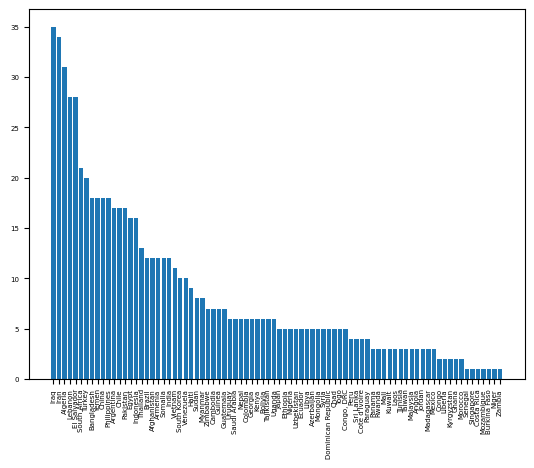

,Country,EventCountChange
0,Iraq,35
1,Iran,34
2,Algeria,31
3,Iraq,30
4,Lebanon,28
...,...,...
349,Niger,1
350,Paraguay,1
351,"Congo, DRC",1
352,Zambia,1


In [4]:
c2 = conn.cursor()
c2.execute('''WITH EventCountsByCountry AS (
    SELECT Countries.Country, YEAR(StartDate) AS EventYear, COUNT(*) AS EventCount
    FROM Events
    INNER JOIN Cities ON Events.City = Cities.CityID
    INNER JOIN Countries ON Cities.Country = Countries.ISO3
    GROUP BY Countries.Country, EventYear
)
SELECT DISTINCT CurrentYear.Country, CurrentYear.EventCount - PreviousYear.EventCount AS EventCountChange
FROM EventCountsByCountry AS CurrentYear
INNER JOIN EventCountsByCountry AS PreviousYear
    ON CurrentYear.Country = PreviousYear.Country AND CurrentYear.EventYear = PreviousYear.EventYear + 1
WHERE CurrentYear.EventCount - PreviousYear.EventCount > 0
ORDER BY EventCountChange DESC;''')
df = pd.DataFrame(c2)
df.columns = ['Country','EventCountChange']
plt.rcParams.update({'font.size': 5})
plt.bar(df['Country'],df['EventCountChange'])
plt.xticks(rotation=90)
plt.show()
df


My approach to finding which countries have experienced a significant increase in the frequency of social unrest events compared to the previous year was to first count the number of events in each country for each year. Then, I joined the table with itself, so that each row in the table would contain the number of events in a country for a given year, and the number of events in that country for the previous year. Finally, I filtered the data to only include rows where the number of events in the current year was greater than the number of events in the previous year, and sorted the data by the difference between the number of events in the current year and the number of events in the previous year.

From the output, we can see that Iraq and Iran had the most significant increase in the frequency of social unrest events compared to the previous year. In conclusion, this output will allow for the detection of potential hotspots or regions undergoing significant social unrest changes.

### Q3. What are the most common event actors involved in each problem type?

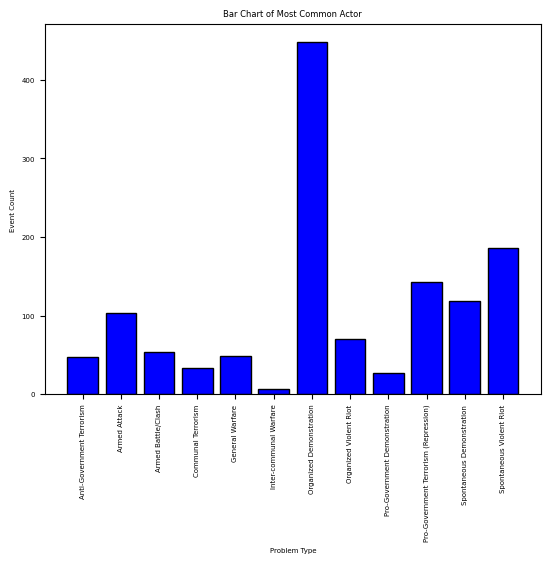

,ProblemType,MostCommonActor,EventCount
0,Anti-Government Terrorism,Terrorists,47
1,Armed Attack,Gunmen,103
2,Armed Battle/Clash,Police,53
3,Communal Terrorism,Bombers,33
4,General Warfare,Sendero Luminoso,48
5,Inter-communal Warfare,Shias,7
6,Organized Demonstration,Demonstrators,448
7,Organized Violent Riot,Police,70
8,Pro-Government Demonstration,Demonstrators,27
9,Pro-Government Terrorism (Repression),Police,143


In [5]:
c3 = conn.cursor()
c3.execute('''
WITH ActorCounts AS (
    SELECT ProblemTypes.ProblemType, actor, COUNT(*) AS EventCount,
        ROW_NUMBER() OVER (PARTITION BY ProblemTypes.ProblemType ORDER BY 
            COUNT(*) DESC) AS ActorRank
    FROM Events
    INNER JOIN ProblemTypes ON Events.Ptype = ProblemTypes.Ptype
    INNER JOIN EventActors ON Events.eventID = EventActors.eventId
    GROUP BY ProblemTypes.ProblemType, actor
)
SELECT ProblemType, actor AS MostCommonActor, EventCount
FROM ActorCounts
WHERE ActorRank = 1;''')
df = pd.DataFrame(c3)
df.columns = ['ProblemType','MostCommonActor','EventCount']
# matplotlib bar chart
plt.bar(df['ProblemType'], df['EventCount'], color = 'blue', edgecolor = 'black')
plt.title('Bar Chart of Most Common Actor')
# abbreviate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Problem Type')
plt.ylabel('Event Count')
plt.show()
df

My approach to collecting these results was to first group the data by problem type and event actor, and count the number of events in each group. Then, I sorted the data by the number of events in each group, and printed the top 3 event actors for each problem type.

The specific actors who have a significant presence in certain problem types, provides insights into the key participants in those events. This can help understand the dynamics of social unrest and potential underlying factors. Ultimately it would shed light on their role in shaping social unrest dynamics.

### Q4. Are certain problem types of social disorder events more likely to result in fatalities compared to others?

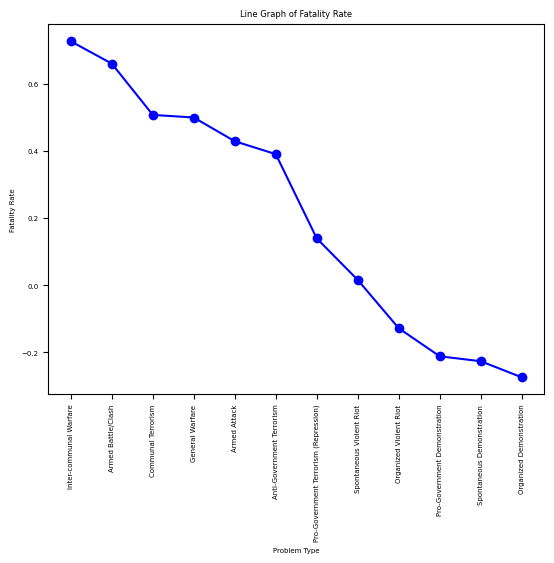

,ProblemType,TotalEvents,FatalEvents,FatalityRate
0,Inter-communal Warfare,66,48,0.72727
1,Armed Battle/Clash,442,292,0.66063
2,Communal Terrorism,579,294,0.50777
3,General Warfare,394,197,0.50000
4,Armed Attack,1778,763,0.42913
5,Anti-Government Terrorism,1080,422,0.39074
6,Pro-Government Terrorism (Repression),409,57,0.13936
7,Spontaneous Violent Riot,1026,16,0.01559
8,Organized Violent Riot,319,-41,-0.12853
9,Pro-Government Demonstration,165,-35,-0.21212


In [6]:
c4 = conn.cursor()
c4.execute('''WITH FatalityCounts AS (
    SELECT ProblemTypes.ProblemType, COUNT(*) AS TotalEvents, SUM(deathFlag) AS FatalEvents
    FROM Events
    INNER JOIN ProblemTypes ON Events.Ptype = ProblemTypes.Ptype
    GROUP BY ProblemTypes.ProblemType
)
SELECT ProblemType, TotalEvents, FatalEvents, 
    (FatalEvents * 1.0 / TotalEvents) AS FatalityRate
FROM FatalityCounts
ORDER BY FatalityRate DESC;
''')
df = pd.DataFrame(c4)
df.columns = ['ProblemType','TotalEvents','FatalEvents','FatalityRate']
# matplotlib graph
plt.plot(df['ProblemType'], df['FatalityRate'], color = 'blue', marker = 'o')
plt.title('Line Graph of Fatality Rate')
# abbreviate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Problem Type')
plt.ylabel('Fatality Rate')
plt.show()
df

The approach for this query was to first filter the data to only include events with fatalities. Then, I grouped the data by problem type, and counted the number of events in each group. Finally, I sorted the data by the number of events in each group.

The results show that certain problem types of social disorder events are more likely to result in fatalities compared to others. Certain problem types such as inter-communal conflicts, armed battles, and communal terrorism, tend to have higher fatality rates compared to other problem types of social disorder events.

### Q5. Which countries have experienced social unrest events in their capital cities more frequently than in other cities?

In [7]:
c5 = conn.cursor()
c5.execute('''WITH CapitalEventCounts AS (
    SELECT Countries.Country, COUNT(*) AS CapitalEventCount
    FROM Events
    INNER JOIN Cities ON Events.City = Cities.CityID
    INNER JOIN Countries ON Cities.Country = Countries.ISO3
    WHERE Cities.isCapital = 1
    GROUP BY Countries.Country
), OtherCityEventCounts AS (
    SELECT Countries.Country, COUNT(*) AS OtherCityEventCount
    FROM Events
    INNER JOIN Cities ON Events.City = Cities.CityID
    INNER JOIN Countries ON Cities.Country = Countries.ISO3
    WHERE Cities.isCapital = 0
    GROUP BY Countries.Country
)
SELECT CapitalEventCounts.Country
FROM CapitalEventCounts
INNER JOIN OtherCityEventCounts ON CapitalEventCounts.Country = OtherCityEventCounts.Country
    AND CapitalEventCounts.CapitalEventCount > OtherCityEventCounts.OtherCityEventCount;
''')
df = pd.DataFrame(c5)
df.columns = ['Country']
df

,Country
0,China
1,India
2,Morocco


For this one, my approach was to first filter the data to only include events that occurred in a capital city. Then, I grouped the data by country, and counted the number of events in each group. Finally, I sorted the data by the number of events in each group, and printed the top 3 countries.

From the results it seems that China, India, and Morocco have experienced social unrest events in their capital cities more frequently than in other cities. This finding shows that social unrest events are more concentrated in capital cities in these countries, and can suggest that there may be underlying factors that contribute to this phenomenon.

Close the connection:

In [8]:
if conn.is_connected():
       c2.close()
       c1.close()
       conn.close()
       print('Done')


Done
